In [1]:
# !pip install yfinance
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib

In [2]:
import numpy as np
import pandas as pd
import sys, os
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# MAKE SURE WE HAVE THE ENVIRONMENT CONFIGURED PROPERLY
%cd ../src/main
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
if 'backend' not in os.listdir('.'):
    sys.path.insert(0, os.path.abspath(SCRIPT_DIR))

from backend.technical_analysis import (
    get_data_set
)
from backend.stock_dataset import (
    StockDataset
)
from backend.reinforcement_learning import (
    rlPolicy
)

/home/jackb/columbia/TFJ-DRL-update1/src/main


Check if GPU is available, if not then use CPU

In [3]:
if torch.cuda.is_available():
    device = torch.device(f'cuda:{torch.cuda.device_count()-1}')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

In [4]:
#Calculate Utility based on policy Output
#z: z from dataset
#c: transaction cost
def calcUtility(policyOutput, z, c=0.0001):
  #with torch.no_grad():
    discretize=policyOutput.detach()
    discretize=(discretize>=0)*2-1
    preAction=torch.cat([discretize[:,0:1], discretize[:, :-1]], dim=1)
    #net income R
    R=z*discretize-c*((discretize-preAction)!=0)
    U=[]
    for i in range(R.shape[1]):
        if(i==0):
            u=R[:,i:i+1]
        else:
            u=R[:,i:i+1]+U[i-1]
        U.append(u)
    U=torch.cat(U, dim=1)
    return U, preAction

In [5]:
#Prevent exploding gradient
def grad_clipping(net: torch.nn.Module, theta): 
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [6]:
#model weight initialization
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.normal_(0.0,0.01)

In [7]:
#Loss function defined by paper
def lossFunc(predP, y, policyOutput, z, device: torch.device):
    #MSE
    term1=nn.MSELoss()(predP, y)
    #RL
    U, preAction=calcUtility(policyOutput, z)
    U_detach=U.detach()
    actionProb=(torch.tensor(1).to(device)+policyOutput)/torch.tensor(2)
    plusMinus=(preAction<0)*1
    term2=-torch.log(1*plusMinus+((-1)**plusMinus)*actionProb)*U_detach
    return term2.mean()+term1

In [8]:
#greedy loss function
def lossFunc2(predP, y, policyOutput, z, device):
    #MSE
    term1=nn.MSELoss()(predP, y)
    #RL
    greedyAction=(z>=0.01)*2.0-1.0
    U, preAction=calcUtility(policyOutput, z)
    U_detach=U.detach()
    actionProb=(torch.tensor(1).to(device)+policyOutput)/torch.tensor(2)
    plusMinus=(preAction<0)*1
    term2=(torch.log(1*plusMinus+((-1)**plusMinus)*actionProb)*U_detach).mean()
    term3=nn.MSELoss()(policyOutput, greedyAction)
    return term3+term2+term1

In [9]:
#trainer for epoch
def train_epoch(net: torch.nn.Module, train_iter: DataLoader, device: torch.device, optimizer: torch.optim.Optimizer):
    loss_data=[]
    with torch.autograd.set_detect_anomaly(True):
        for X, y, z, _ in train_iter:
            #reset state for each batch
            state=net.begin_state(batch_size=X.shape[0], device=device)
        
            #move to device
            X, y, z=X.to(device), y.to(device), z.to(device)
            predP, output=net(X, state)
            loss=lossFunc2(predP, y, output,z, device)
            optimizer.zero_grad()
            loss.backward()
            grad_clipping(net, 1)
            optimizer.step()
            loss_data.append(loss.item())
    return np.array(loss_data).mean(), loss_data

In [10]:
#Testing on trained model
def prediction(net: torch.nn.Module, eval_iter: DataLoader, device: torch.device):
    net.eval()
    loss_list=[]
    U_list=[]
    with torch.no_grad():
        for X, y, z, _ in eval_iter:
            X, y, z = X.to(device), y.to(device), z.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            predP, output=net(X, state)
            loss=lossFunc2(predP, y, output, z, device)
            U, _=calcUtility(output, z)
            loss_list.append(loss.cpu().numpy())
            U_list.append(U[:, -1].mean().cpu().numpy())
    return np.array(loss_list).mean(), np.array(U_list).mean()

In [11]:
#Trainer 
#Incoporated learning rate scheduler
#Avg training loss & Avg validation Utility gain is recorded on epoch basis
#Loss and Utility by epoch are plotted at the end of training
def train(net: torch.nn.Module, train_iter: DataLoader, eval_iter: DataLoader, optimizer: torch.optim.Optimizer, device: torch.device, num_epoch: int, name: str):
    loss_data=[]
    U_data=[]
    net.apply(init_weights)
    net.to(device)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95, last_epoch=-1)
    
    for epoch in range(num_epoch):
        net.train()
        lossEpoch, lossEpoch_list=train_epoch(net, train_iter, device, optimizer)   
        loss_v, U_v=prediction(net, eval_iter, device)
        loss_data.append(lossEpoch)  
        U_data.append(U_v)
        print(f'Epoch {epoch}, training loss: {lossEpoch:.2f}, val utility: {U_v:.2f}')
        torch.save(net.state_dict(), os.path.join('./model_weights', f'{name}-epoch-{epoch+1}.pth'))
        scheduler.step()
    
    #plot loss & Utility
    fig, ax_left = plt.subplots()
    ax_right = ax_left.twinx()
    ax_left.plot(loss_data, label = "Loss", color='blue')
    ax_right.plot(U_data, label = "Utility", color='red')
    ax_left.set_xlabel('Time Step')
    ax_right.set_ylabel('Loss y axis')
    ax_right.set_ylabel('Utility y axis')
    ax_left.set_title('Loss and Utility')
    ax_left.legend()
    ax_right.legend()
    return loss_data

In [12]:
#Generation of training, validation, and testing dataset
def DataIterGen(test_id_list, val_id_list, name_list, full_list, demo=False, bsize=32) -> tuple[DataLoader, DataLoader, DataLoader]:
    """
    test_id_list: id of subjects for testing
    val_id_list: id of subjects for validation
    other subjects for training
    full_list=get_data_set(name_list), preprocessed
    demo: when demo mode is True, only test_iter is returned, with data from
    first entry of test_id_list (single stock)
    """
    name_count=len(name_list)

    if demo:
        test_iter=DataLoader(StockDataset(test_id_list[0:1], full_list, timestep=24, gap=1), shuffle=False, batch_size=64, num_workers=0)
        print(f'Demo with stock: {name_list[test_id_list[0]]} ')
        return test_iter
    else:
        train_list=set(name_list)-set([name_list[i] for i in test_id_list])-set([name_list[i] for i in val_id_list])
        train_count=len(train_list)
        partial_list=get_data_set(train_list)
        test_iter=DataLoader(StockDataset(test_id_list, full_list), batch_size=bsize, num_workers=0)
        val_iter=DataLoader(StockDataset(val_id_list, full_list), batch_size=bsize, num_workers=0)
        train_iter=DataLoader(StockDataset(list(range(train_count)), partial_list), shuffle=True, batch_size=bsize, num_workers=0)
        print(f'Val: {[name_list[val_id] for val_id in val_id_list]}, Test: {[name_list[test_id] for test_id in test_id_list]}, Train: {train_list} ')
        return train_iter, val_iter, test_iter

In [13]:
def test(net: torch.nn.Module, test_iter, device: torch.device, epoch, name):
    net.eval()
    net.load_state_dict(torch.load(os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth')))
    net.to(device)
    U_list=[]
    with torch.no_grad():
        for X, _, _, zp in test_iter:
            X, zp = X.to(device),  zp.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            predP, output=net(X, state)
            U, _=calcUtility(output, zp)
            U_list.append(U[:, -1].mean().cpu().numpy())
    return np.array(U_list).mean()

In [14]:
def demo(net: torch.nn.Module, demo_iter, device: torch.device, epoch, name):
    net.eval()
    net.load_state_dict(torch.load(os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth')))
    net.to(device)
    reward=np.array([])
    with torch.no_grad():
        for X, _, _, zp in demo_iter:
            X, zp = X.to(device),  zp.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            predP, output=net(X, state)
            discretizedAction=((output>=0)*2-1)
            batchReward=discretizedAction*zp
            reward=np.concatenate((reward,batchReward[:,-1].reshape(-1).cpu().numpy()))
        result = [sum(reward[ : i + 1]) for i in range(len(reward))] 
    fig, ax_left = plt.subplots(figsize=(20,4))
    ax_left.plot(result, label = "Stock Gain", color='blue')
    ax_left.set_xlabel('Time Step')
    ax_left.set_ylabel('Cumulative Gain')
    ax_left.set_title('Demonstration of Algorithm')
    ax_left.legend()
    return 

In [15]:
#Data Generation

stockList1=['COO','COF','ABBV','CCL','AMD','GOOG',
            #'ABMD',
            'ABT','ACN','ADBE','AES','NVDA',
            'AIG','ALL', 'AMG','AMZN','APA','AAPL',
            #'ATVI',
            'AXP','BA','BBY','CAT','GE',
            'CSCO', 
            #'DRE',
            'EA','EQR','FCX','FE',
            'HST','IBM','INTC','JCI','MMM','MO',
            'ORCL','PPL','T','EXPD','VMC','VNO']
if 'stock_dataset.npy' in os.listdir('../data'):
    full_list = np.load(file='../data/stock_dataset.npy')
    print("Loaded previous generation")
else:
    print("Generating new dataset")
    full_list=get_data_set(stockList1, start="2017-01-01", end="2020-01-01", verbose=True, coint_threshold=0.1)
    np.save(file='../data/stock_dataset.npy', arr=full_list)

print(f"Loaded dataset of {full_list.shape[0]} tickers, {full_list.shape[1]} ticks, {full_list.shape[2]} features/tick.")

Loaded previous generation
Loaded dataset of 39 tickers, 664 ticks, 86 features/tick.


In [16]:
train_iter, val_iter, test_iter=DataIterGen([0,1],[2,3,4], stockList1, full_list)

Val: ['ABBV', 'CCL', 'AMD'], Test: ['COO', 'COF'], Train: {'FE', 'ACN', 'EXPD', 'ABT', 'ORCL', 'ALL', 'BBY', 'MMM', 'T', 'MO', 'APA', 'JCI', 'CSCO', 'EA', 'AMG', 'EQR', 'FCX', 'IBM', 'AMZN', 'ADBE', 'AAPL', 'VMC', 'INTC', 'VNO', 'AES', 'BA', 'CAT', 'AXP', 'NVDA', 'HST', 'PPL', 'AIG', 'GOOG', 'GE'} 


Epoch 0, training loss: 1.26, val utility: 2.06
Epoch 1, training loss: 0.62, val utility: 2.77
Epoch 2, training loss: 0.45, val utility: 2.91
Epoch 3, training loss: 0.37, val utility: 2.88
Epoch 4, training loss: 0.31, val utility: 3.27
Epoch 5, training loss: 0.27, val utility: 3.12
Epoch 6, training loss: 0.25, val utility: 3.06
Epoch 7, training loss: 0.20, val utility: 2.98
Epoch 8, training loss: 0.19, val utility: 3.09
Epoch 9, training loss: 0.16, val utility: 3.04
Epoch 10, training loss: 0.16, val utility: 2.91
Epoch 11, training loss: 0.15, val utility: 2.95
Epoch 12, training loss: 0.14, val utility: 2.93
Epoch 13, training loss: 0.13, val utility: 2.98


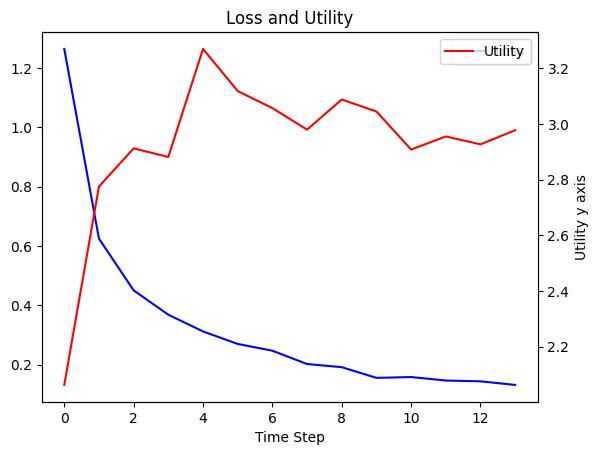

In [17]:
#Training in action
os.makedirs('../model_weights', exist_ok=True)

net=rlPolicy(128, device)
optim1 = optim.Adam(net.parameters(), lr=0.00006, weight_decay=0.01)
loss=train(net, train_iter, val_iter, optim1, device, 14, 'DLRL_full_model')

In [18]:
avgReturn=test(net, test_iter, device, 14, 'DLRL_full_model')
print(f'On average, every 24 days the algorithm yields: {avgReturn}' )

On average, every 24 days the algorithm yields: 5.1429948806762695


Demo with stock: COF 


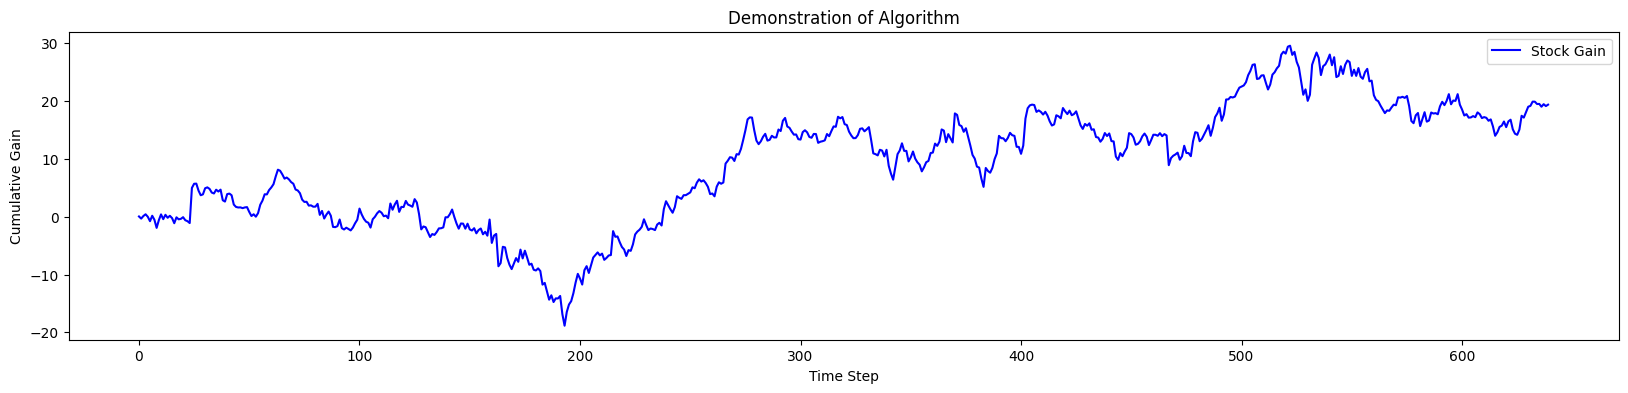

In [19]:
demo_iter=DataIterGen([1],[], stockList1,full_list, demo=True)
demo(net, demo_iter , device, 14, 'DLRL_full_model')

Demo with stock: COO 


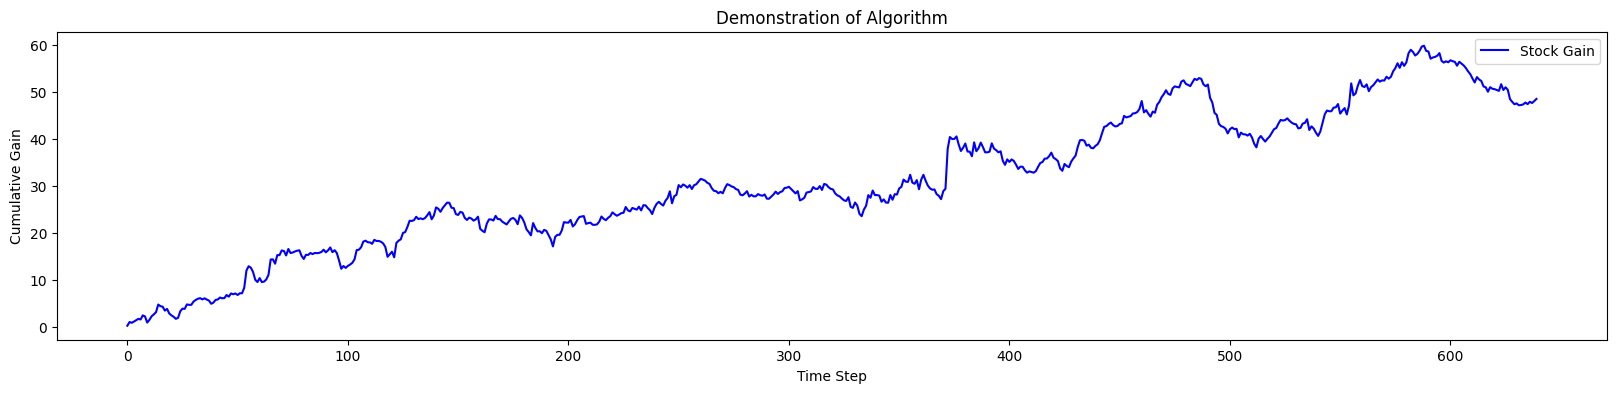

In [20]:
demo_iter=DataIterGen([0],[], stockList1,full_list, demo=True)
demo(net, demo_iter , device, 14, 'DLRL_full_model')